In [19]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display
import typing
%matplotlib inline

In [20]:
iris_db = datasets.load_iris(as_frame=True)
# sn.pairplot(iris_db.data)

In [21]:
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [22]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)


y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

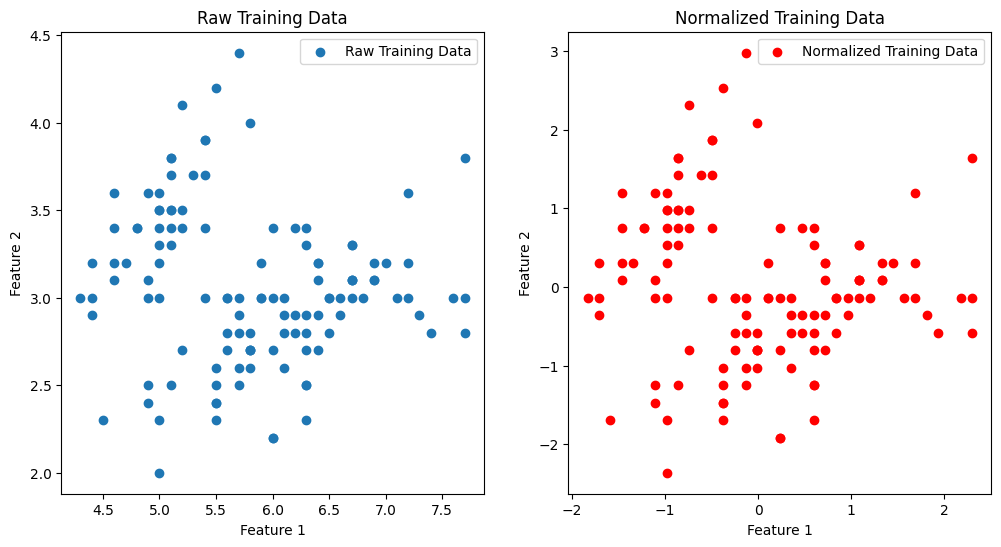

In [23]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:

    x_normalise = (x-mu)/sigma
    return x_normalise

x_train_mean = torch.mean(x_train, dim=0)
x_train_std = torch.std(x_train, dim=0)
x_train_norm = norm_set(x_train, x_train_mean, x_train_std)

x_test_norm=norm_set(x_test, x_train_mean, x_train_std)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0].numpy(), x_train[:, 1].numpy(), label="Raw Training Data")
plt.title("Raw Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()


plt.subplot(1, 2, 2)
plt.scatter(x_train_norm[:, 0].numpy(), x_train_norm[:, 1].numpy(), label="Normalized Training Data",color="red")
plt.title("Normalized Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.show()

By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

(1.5, 4.9)

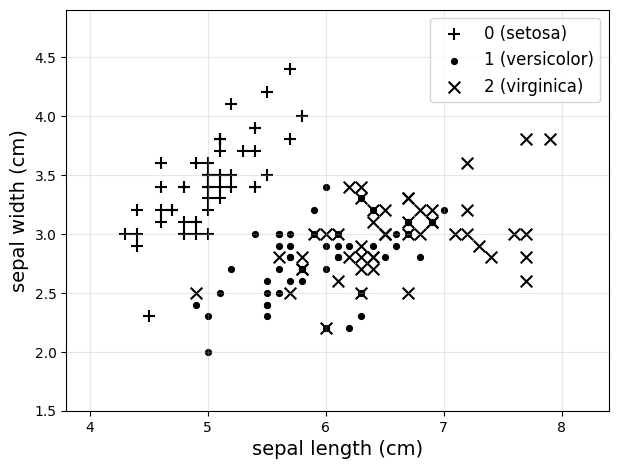

In [24]:
X = iris_db.data.iloc[:, :2]
Y = iris_db.target
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0],
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l],
      s=70,
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)


Is the data linearly separable?

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [25]:
train_set_1 = x_train_norm[:, :2]
test_set_1 = x_test_norm[:, :2]

# add a feature for bias
train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1)
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()

## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $

**Q2.** First implement the above function in `def sigmoid()`. [2 marks]

**Q3.** Then, using the implementation of `LinearRegression` from last week as guideline, create a custom pytorch layer for `LogisticRegression` [2 marks]

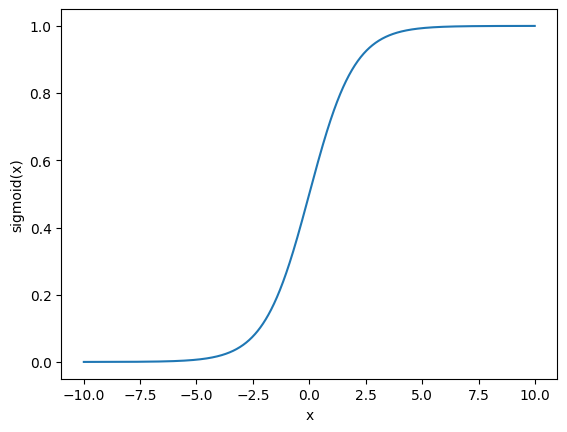

In [26]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
                                                            
    z=1 / (1 + torch.exp(-z))
    return z


x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [27]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    # super().__init__()
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)
    # self.linear = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)
       
  def forward(self, x):
    # y = linear(x)
    linear=(torch.matmul(x,self.weight.t()))
    # y = torch.(y)
    return sigmoid(linear)

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$



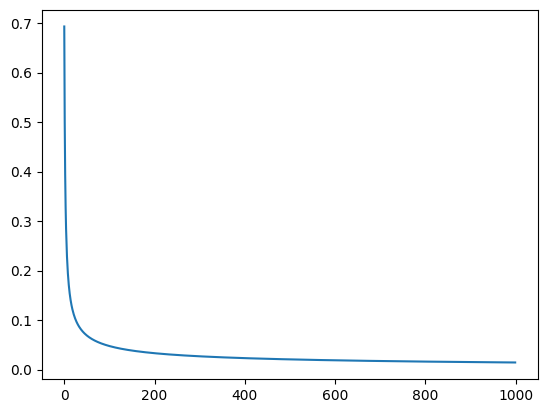

Parameter containing:
tensor([[-7.6483,  4.1452, -4.5710]])
Minimum cost: 0.01426516380161047


In [28]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  m = y_true.shape[0]
  loss = torch.mean(-y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred))
  return loss

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y:torch.Tensor, y_pred:torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]
  weight -= (1/N)*lr*(torch.matmul((y_pred-y).t(),X))
  # gradient =  torch.mm((y_pred - y).t(), X)/N 
  gradients = (1 / N) * torch.mm((y_pred - y).t(), X)
  
  model.weight =nn.Parameter(weight, requires_grad=False)  
  
def train(model, x, y, alpha):
  cost_lst = list()
  for it in range(1000):
    prediction = model(x)
    cost = bce(y, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x, y,prediction, alpha)
  display.clear_output(wait=True)
  plt.plot(list(range(it+1)), [cost.detach().numpy() for cost in cost_lst])
  plt.show()
  for param in model.parameters():
    print(param)

  print('Minimum cost: {}'.format(min(cost_lst)))

model = LogisticRegression(train_set_1.shape[1])
alpha = 1 # select an appropriate lr
train(model, train_set_1, setosa_train, alpha)

[-7.648283  4.1452  ]


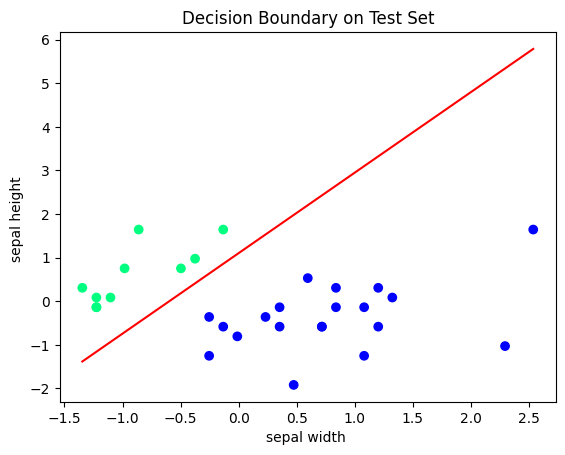

In [29]:
import matplotlib.pyplot as plt
import numpy as np
# Extract model parameters
# Adjust these lines based on your model's structure
weight = model.weight.data.numpy()[0][:2]
print(weight)
bias = model.weight.data.numpy()[0][-1]

x1 = np.linspace(test_set_1[:, 0].min(), test_set_1[:, 0].max(), 100)
x2 = - (bias / weight[1]) - (weight[0] / weight[1]) * x1


plt.scatter(test_set_1[:, 0], test_set_1[:, 1], c=setosa_test, cmap='winter')  
plt.plot(x1, x2, color='red')  # Decision boundary
plt.xlabel('sepal width ')
plt.ylabel('sepal height ')
plt.title('Decision Boundary on Test Set')
plt.show()


## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach (refer to the lecture notes for details). We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer.

In [30]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
print(y_test.shape,y_train.shape)

torch.Size([30, 3]) torch.Size([120, 3])


In this section we will use the built in pytorch methods.


In [31]:
alpha = 0.1
setosa_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))


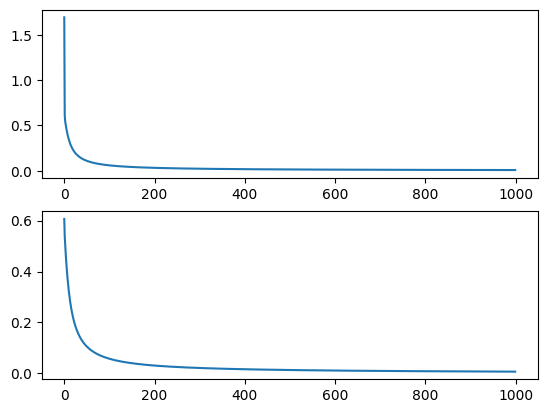

Minimum train cost: 0.0074458313174545765
Minimum test cost: 0.007137917913496494


In [32]:
train(setosa_model, x_train, setosa_labels, x_test, setosa_testy, optimiser, alpha)

How does the cost of the 4 attribute model compare to the previous one?

**Q6** Now train classifiers for the other two classes.[1 mark]

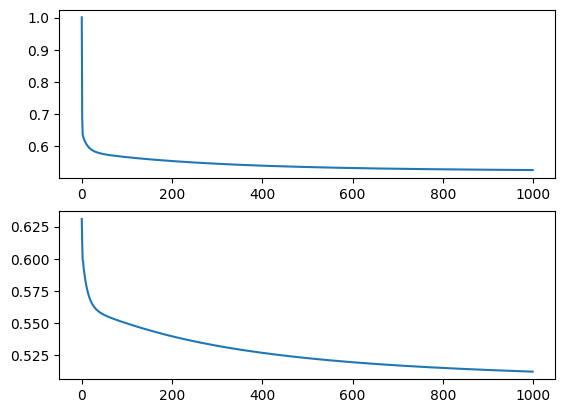

Minimum train cost: 0.5256066918373108
Minimum test cost: 0.5120132565498352


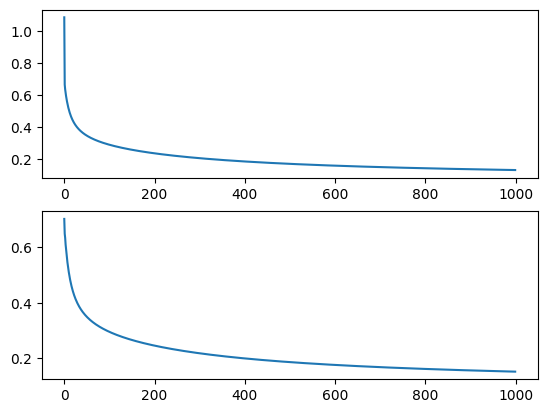

Minimum train cost: 0.1294557899236679
Minimum test cost: 0.1517462581396103


In [33]:
alpha = 0.1
versicular_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
versicular_labels = y_train[:, 1].reshape(-1, 1).float()
versicular_testy = y_test[:, 1].reshape(-1, 1).float()
optimiser = optim.SGD(versicular_model.parameters(), alpha)

train(versicular_model, x_train, versicular_labels, x_test, versicular_testy, optimiser, alpha)

alpha = 0.1
verginica_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
verginica_labels = y_train[:, 2].reshape(-1, 1).float()
verginica_testy = y_test[:, 2].reshape(-1, 1).float()
optimiser = optim.SGD(verginica_model.parameters(), alpha)


train(verginica_model, x_train, verginica_labels, x_test, verginica_testy, optimiser, alpha)


In [34]:
test_pred_setosa= setosa_model(x_test)
test_pred_versicular=versicular_model(x_test)
test_pred_verginica=verginica_model(x_test)

predictionList = torch.cat([test_pred_setosa.unsqueeze(1),test_pred_versicular.unsqueeze(1),test_pred_verginica.unsqueeze(1)], dim=1)


ClassPred = torch.argmax(predictionList, dim=1)

actualPred = torch.argmax(y_test, dim=1) if y_test.ndim > 1 else y_test


predictionOfClasses = ClassPred.numpy().flatten()
actualValuesOfClasses = actualPred.numpy().flatten()

table = pd.DataFrame({'Predicted Values': predictionOfClasses,'Actual Values': actualValuesOfClasses})

# Display the DataFrame
print(table)

    Predicted Values  Actual Values
0                  1              1
1                  0              0
2                  2              2
3                  1              1
4                  1              1
5                  0              0
6                  1              1
7                  2              2
8                  1              1
9                  1              1
10                 2              2
11                 0              0
12                 0              0
13                 0              0
14                 0              0
15                 1              1
16                 2              2
17                 1              1
18                 1              1
19                 2              2
20                 0              0
21                 2              2
22                 0              0
23                 2              2
24                 2              2
25                 2              2
26                 2        

In [35]:
test_pred_setosa_np = test_pred_setosa.detach().numpy()
test_pred_versicular_np = test_pred_versicular.detach().numpy()
test_pred_verginica_np = test_pred_verginica.detach().numpy()

concatenated_pred = torch.cat((test_pred_setosa, test_pred_versicular, test_pred_verginica), dim=1)
softmax =torch.softmax(concatenated_pred,dim=1)
# print(concatenated_pred)
correct_pred = (torch.argmax(softmax,dim=1) == torch.argmax(y_test,dim=1)).sum().item()
total_pred = y_test.size(0)
accuracy=correct_pred/total_pred

print(accuracy)





1.0


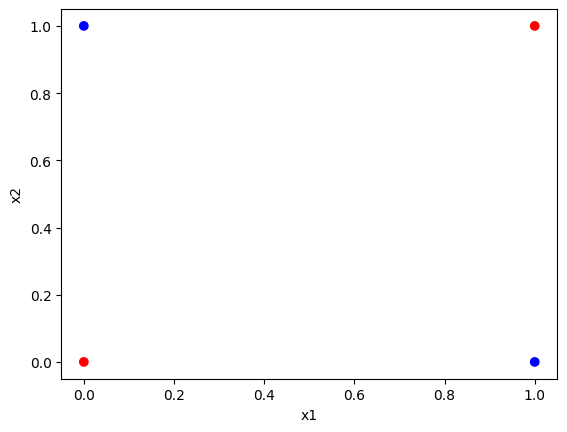

In [36]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()